In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

from embeddings.solver import Solver
from embeddings.datasets import (
    erdos_renyi_dataset,
    watts_strogatz_dataset,
    barabasi_albert_dataset,
    all_combined_dataset,
    combine
)
from main import (
    get_model_dir,
    epochs,
    batch_size,
    lr,
    embedding_size,
    commit_hash_latest_model
)
from embeddings.feature_generators import (
    degree_ones_features,
    degree_sorted_features,
    degree_rand_features,
    degree_sorted_random_features,
)


from utils import load_pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict

In [2]:
base_dir = "../"
data_dir = os.path.join(base_dir, "data/synthetic")
model_base_dir = os.path.join(base_dir, "embeddings/models")

In [3]:
def get_scores(train_data, test_data, k=2, description='', comm_hash=None):
    print('retrieveing scores')
    
    if comm_hash is None:
        comm_hash = commit_hash_latest_model
    model_dir = get_model_dir(model_base_dir, train_data, k, feature_gen, description, comm_hash, must_exist=True)
    print("loading model from:", model_dir)
    
    if not os.path.exists(model_dir):
        raise ValueError("Could not load pretrained model")
        
    solver = Solver(embedding_size=embedding_size, k=k, model_dir=model_dir, load=True)
    
    return solver.compute_scores(test_data)

def get_graph_info(graph_dir):
    samples = 10
    n = 0
    m = 0
    for i in range(samples):
        f_name = os.path.join(data_dir, graph_dir, 'G_{}.pkl'.format(i))
        G = load_pickle(f_name)
        n += len(G)
        m += G.number_of_edges()
    
    n = 1. * n / samples
    m = 1. * m / samples
    density = m / (n * (n-1))
    return n, m, density

def get_df(scores):
    df_dict = defaultdict(lambda: [])
    for graph_dir in scores:
        n, m, density = get_graph_info(graph_dir)
        
        df_dict['graph_dir'].append(graph_dir)
        for col in scores[graph_dir]:
            df_dict[col].append(np.array(scores[graph_dir][col]))
        df_dict['n'].append(n)
        df_dict['m'].append(m)
        df_dict['density'].append(density)

    df = pd.DataFrame(df_dict)
    df['r_to_kern'] = df.apply(lambda x: np.mean(x.weight_kern_lin) / np.mean(x.weight_random), axis=1)
    df['r_to_pred'] = df.apply(lambda x: np.mean(x.weight_pred) / np.mean(x.weight_random), axis=1)
    df['mean_imbalance'] = df['imbalance'].apply(np.mean)

    return df

def plot_performance(train_data, test_data, k=2, description='', comm_hash=None):
    
    scores = get_scores(train_data, test_data, k, description, comm_hash)
    print('building df')
    df = get_df(scores)
    sns.set()
    # plot by size
    #plt.plot(df['n'], df['weight_pred'].apply(np.mean))
    
    # plot by density
    for size in set(df['n']):
        df_s = df[df['n'] == size]
        df_s = df_s.sort_values(by='density')
        plt.scatter(df_s['density'], df_s['r_to_pred'])
        plt.scatter(df_s['density'], df_s['r_to_kern'])
        plt.legend(['predictions / random', 'kern.-lin / random'], loc='best')
        plt.title('cut weights for graphs of size {}'.format(size))
        plt.xlabel('graph density')
        plt.show()
        plt.scatter(df_s['density'], df_s['mean_imbalance'])
        plt.title('imbalance for graphs of size {}'.format(size))
        plt.legend(['mean imbalance'])
        plt.xlabel('graph density')
        plt.show()
        
    return df

In [4]:
# Select dataset and model

commit_hash_model = None
feature_gen = degree_rand_features
train_data = all_combined_dataset(base_dir=data_dir, indices=range(80), compute_features=feature_gen)
test_data = all_combined_dataset(base_dir=data_dir, indices=range(80, 100), compute_features=feature_gen)

  0%|          | 0/980 [00:00<?, ?it/s]

retrieveing scores
loading model from: ../embeddings/models/9baf90f8cde23a1c810ed056217db588448ea225


100%|██████████| 980/980 [00:40<00:00, 24.16it/s]


building df


/home/anton/miniconda3/envs/cutml/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/anton/miniconda3/envs/cutml/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


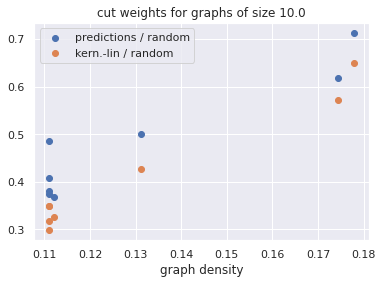

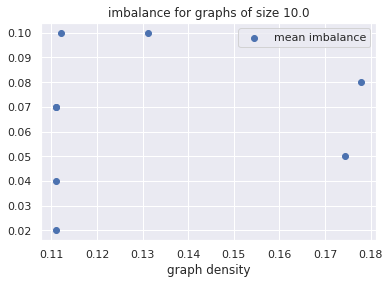

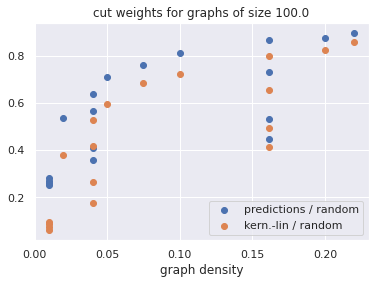

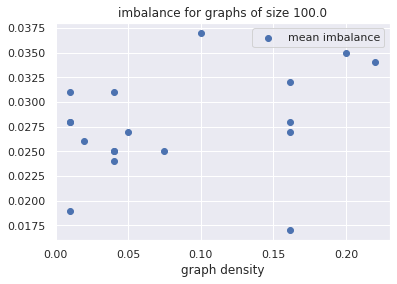

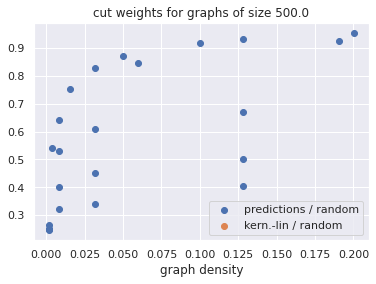

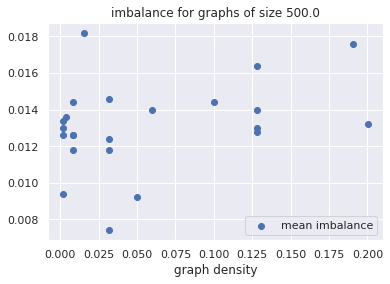

In [5]:
df = plot_performance(train_data, test_data)